####Imports cell

In [3]:
# Object imports
import numpy as np
import pandas as pd
import torch

# Image handle imports
import cv2
from PIL import Image

# Data handle imports
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader

# Others
import random
import torch.nn as nn
from torchvision import transforms, models
import matplotlib.pyplot as plt
import os
import zipfile

The file 'all_data_info.csv' is store all the information about the data we will on our Siamese model.
With Csv reader variable we could investigate the data, and from there decide how to build the model.

In [31]:
# CSV variable
all_data_csv = pd.read_csv('../Data/CSV/all_data_info.csv')
# Look at the first 20 images of the data
all_data_csv.head(20)

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg
5,Tosa Mitsuoki,NaN,mythological painting,25528.0,3000.0,10496349.0,wikiart,Yamato-e,Night March of a Hundred Demons (left half),train_only,True,29855.jpg
6,Barnett Newman,NaN,abstract,7345.0,8640.0,6383948.0,wikiart,Color Field Painting,"Who’s Afraid of Red, Yellow and Blue II",train_only,True,62252.jpg
7,Hiroshige,1838,bird-and-flower painting,6483.0,9276.0,12762418.0,wikiart,Ukiyo-e,Small Bird on a Branch of Kaidozakura,train_and_test,False,49823.jpg
8,Barnett Newman,1963.0,abstract,6049.0,8206.0,1135960.0,wikiart,Color Field Painting,Black Fire I,train_only,True,63861.jpg
9,Franz Richard Unterberger,NaN,cityscape,6238.0,7352.0,7896792.0,wikiart,Romanticism,Procession in Naples,train_and_test,False,84512.jpg


In [156]:
total_num = len(all_data_csv)
train_only_num = len([x for x in all_data_csv["artist_group"].values if x == 'train_only'])
test_only_num = len([x for x in all_data_csv["artist_group"].values if x == 'test_only'])
train_and_test_num = len([x for x in all_data_csv["artist_group"].values if x == 'train_and_test'])

artist_num = len(all_data_csv['artist'].unique())
genres_num = len(all_data_csv["genre"].dropna().unique())

pixelsx_mean = all_data_csv["pixelsx"].mean()
pixelsx_var = all_data_csv["pixelsx"].var()
pixelsx_max = int(all_data_csv["pixelsx"].max())
pixelsx_min = int(all_data_csv["pixelsx"].min())

pixelsy_mean = all_data_csv["pixelsy"].mean()
pixelsy_var = all_data_csv["pixelsy"].var()
pixelsy_max = int(all_data_csv["pixelsy"].max())
pixelsy_min = int(all_data_csv["pixelsy"].min())

average_paints_per_artist = all_data_csv['artist'].value_counts().mean()

# To check number of images with not NaN genre value
#Nan_genres_num = len(all_data_csv.loc[pd.isna(all_data_csv["genre"]) == False])

print(f'Total number of images in the data: {total_num}')
print(f'The Split of the data between Train only/Train and Test/ Test only is: {train_only_num}/{train_and_test_num}/{test_only_num}\n')

print(f'Number of different genres: {genres_num}')
print(f'Average paints per artist in this set: {average_paints_per_artist:.2f}\n')

print(f'The average size of X axis per image is {pixelsx_mean:.2f} pixel, and average size of Y axis per image is {pixelsy_mean:.2f}')
print(f'The highest (X, Y) measurements are ({pixelsx_max}, {pixelsy_max}), and the lowest are ({pixelsx_min}, {pixelsy_min})')
print(f'The variances of the axis measurements are ({pixelsx_var:.2f}, {pixelsy_var:.2f})')

Total number of images in the data: 103250
The Split of the data between Train only/Train and Test/ Test only is: 14164/86150/2936

Number of different genres: 42
Average paints per artist in this set: 44.52

The average size of X axis per image is 960.81 pixel, and average size of Y axis per image is 984.09
The highest (X, Y) measurements are (25528, 9541), and the lowest are (200, 162)
The variances of the axis measurements are (355538.29, 390799.19)


Presentation of random images from the dataset
Note: Not all the images are presented in their correct color format.

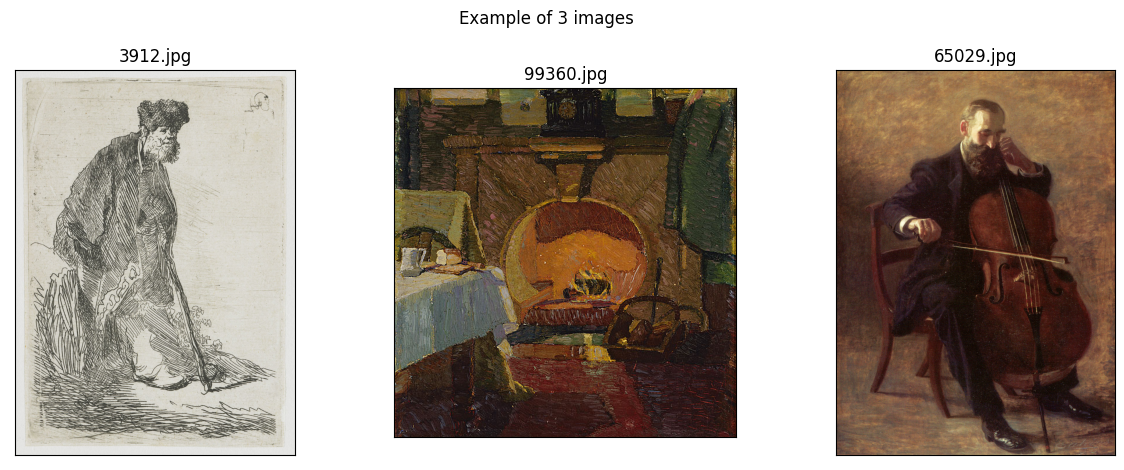

In [105]:
# Example:
img_folder_path = '../Data/Images/training/train'

plt.figure(figsize=(15,5))

for i in range(1,4):
    # choose a image file randomly from the training data
    random_image_name = random.choice(os.listdir(img_folder_path))

    # unzip image with color conversion
    archive = zipfile.ZipFile("../Data/Zips/train.zip", 'r')
    image_data = archive.open("train/" + random_image_name)
    image = Image.open(image_data)

    # presenting the 3 images in a row
    plt.subplot(1, 3, i)
    plt.title(random_image_name)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.asarray(image))

plt.suptitle(f"Example of {3} images", y=1.001)
plt.show()

This cell I tried different ways to check how to present the image in the correct format color

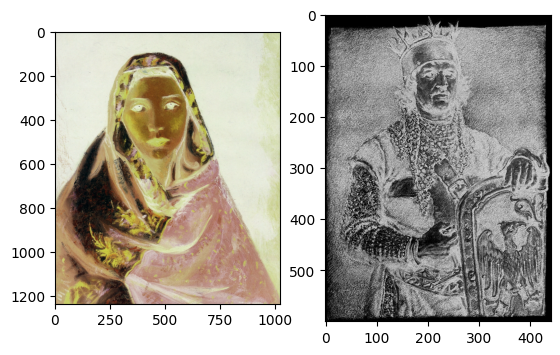

In [106]:
import imghdr
#image = cv2.imread('../Data/Images/training/train/95010.jpg')
#plt.imshow(image)
#plt.show()
try:
    for i in range(1):

        archive = zipfile.ZipFile("../Data/Zips/train.zip", 'r')
        img_path = 'train/'
        #imgdata = archive.open(img_path+'75861.jpg')
        #print(imghdr.what("../Data/Images/training/train/"+'75861.jpg'))
        #print(img.getType())
        #image = Image.open(image_data)
        #print(image.format)
        image = cv2.imread("../Data/Images/training/train/"+"42790.jpg")
        image2 = cv2.imread("../Data/Images/training/train/"+"75861.jpg")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = 255 - image[:,:]
        image2 = 255 - image2[:,:]
        #print(imgdata)
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.subplot(1, 2, 2)
        plt.imshow(image2)
    plt.show()
except Image.DecompressionBombError:
    print("error")
#try:
#    image = cv2.imread('../Data/Images/training/train/72255.jpg')
#    #plt.imshow(image)
#    #plt.show()
#except Image.DecompressionBombError:
#    print("error")

#### Data Load

In [ ]:
#nn_data = ImageDataset(file_path, active_df, LabEnc, img_size=224, normalize=True, crop=False)